<a href="https://colab.research.google.com/github/adrianradian/kneed_compass_gait/blob/master/kinda_working_costfunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Searching for Limit Cycles via Trajectory Optimization

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/underactuated.html?chapter=drake).

In [1]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0  10.2M      0  0:00:19  0:00:19 --:--:-- 12.1M
Reading package lists...
Building dependency tree...
Reading state information...
libjpeg8 is already the newest version (8c-2ubuntu8).
libjpeg8 set to manually installed.
libjsoncpp1 is already the newest version (1.7.4-3).
libjsoncpp1 set to manually installed.
liblapack3 is already the newest version (3.7.1-4ubuntu1).
liblapack3 set to manually installed.
libogg0 is already the newest version (1.3.2-1).
libogg0 set to manually installed.
libtheora0 is already the newest version (1.1.1+dfsg.1-14).
libtheora0 set to manually installed.
libxt6 is already the newest version (1:1.1.5-1).
libxt6 set to manually installed.
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
zlib1g is already the newest v

In [0]:
# others
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# drake
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq, le, ge, GetInfeasibleConstraints)
from pydrake import symbolic
from pydrake import math
from underactuated import FindResource
import drake
import pydrake

#Importing the URDF file for The Kneed Walker


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'12uxHHOS9cgRSxI0SBKku0-qLoXOAHE-x'}) # replace the id with id of file you want to access
downloaded.GetContentFile('kneed_compass_gait.urdf') 

In [0]:
#downloaded = drive.CreateFile({'id':'1ViJ1_3a1ziq6wBPLt0fmOqfnuZd8-rV_'}) # replace the id with id of file you want to access
#downloaded.GetContentFile('compass_gait.urdf') 

In [7]:
import pandas as pd
xyz = pd.read_csv('kneed_compass_gait.urdf') 
print(xyz.head(1))

  <?xml version="1.0" ?>
0   <!-- Let's change-->


#SET VELOCITY HERE
If the velocity is above 1.4 we get an error when we try to find out which constraint that failed.

In [0]:
#na = 3
#nq = 5

#prog = MathematicalProgram()
#h = prog.NewContinuousVariables(rows=T, cols=1, name='h')
#qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
#d = prog.NewContinuousVariables(1, name='d')
#u = prog.NewContinuousVariables(rows=T, cols=na, name='u')

#prog.AddBoundingBoxConstraint([1], [10], d).evaluator().set_description('d bounding box')

#def energyCost(vars):
#    assert vars.size == 2*na + 1 + 1
#    split_at = [na, 2*na, 2*na + 1]
#    qd, u, h, d = np.split(vars, split_at)
#    return pydrake.math.abs([qd.dot(u)*h/d])

#for t in range(T):
#    vars = np.concatenate((qd[t, 2:], u[t,:], h[t], d))
#    prog.AddCost(energyCost, vars=vars)

#initial_guess = np.empty(prog.num_vars())
#solver = SnoptSolver()
#result = solver.Solve(prog, initial_guess)
#print(f'Solution found? {result.is_success()}.')

## Parse the `urdf` and Get the `MultibodyPlant`

We start by defining a couple of physical parameters that we will need below.

In [0]:
# friction coefficient between feet and ground
friction = .2

# position of the feet in the respective leg frame
# (must match the urdf)
foot_in_leg = {
    'stance_leg': np.zeros(3),        # stance foot in stance-leg frame
    'swing_leg': np.array([0, 0, -1]) # swing foot in swing-leg frame
}

In [0]:
# parse urdf and create the MultibodyPlant
kneed_compass_gait = MultibodyPlant(time_step=0)
file_name = 'kneed_compass_gait.urdf'
Parser(kneed_compass_gait).AddModelFromFile(file_name)
kneed_compass_gait.Finalize()

# overwrite MultibodyPlant with its autodiff copy
kneed_compass_gait = kneed_compass_gait.ToAutoDiffXd()

# number of configuration variables
nq = kneed_compass_gait.num_positions()

# number of components of the contact forces
nf = 2

# number of actuators (There are three, but only two of them are used at each step. The knee actuator at the stance leg is not used)
na = 3

# number of knee torques
nk = 1

# number of kneestrike impulse forces. Only torque at q4
ni = 1

## Helper Functions for the `MathematicalProgram`

When writing a `MathematicalProgram` in Drake, optimization variables are `symbolic.Variable` objects.
These cannot be passed directly to the `MultibodyPlant` functions (such as `CalcMassMatrix`), which only accept floats or `AutoDiffXd` types.
Hence, if you need to add a constraint which involves the evaluation of a `MultibodyPlant` function, you need to proceed as follows.

Write a python function (say `my_fun`) that, given the numeric value (`float` or `AutoDiffXd`) of certain variables in the problem, returns the numeric value of the quantity that you want to constrain.
Let `vars` be the arguments of this function and `values` its output (both can be arrays).
Using the method `MathematicalProgram.AddConstraint` you can write `prog.AddConstraint(my_fun, lb=values_lb, ub=values_ub, vars=vars)` to enforce the constraints `values_lb <= values <= values_ub`, where `value_lb` and `value_ub` are vectors of floats of appropriate dimensions.
Then, at solution time, the solver will evaluate `my_fun` passing autodiff variables, retrieving in this way the numeric values of the constraint violations and their derivatives.

In the following cell we wrote the functions that we will need to enforce the necessary constraints in the trajectory optimization problem.

In [0]:
# Function that given the current configuration, velocity,
# acceleration, and contact force at the stance foot, evaluates
# the manipulator equations. The output of this function is a
# vector with dimensions equal to the number of configuration
# variables. If the output of this function is equal to zero
# then the given arguments verify the manipulator equations.
def manipulator_equations(vars):
    
    # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force


    assert vars.size == 3 * nq + nf + na + nk
    # (number_of_derivatives + 1)*(x,y,q1,q2,q3) 
    # + number of forces on stance foot(Fx, Fy) + number of actuators (3)

    #We split the vector at certain locations so that we get:
    #[0:nq-1], [nq:2*nq-1], [2nq:3*nq-1] and so on
    split_at = [nq, 2 * nq, 3 * nq, 3*nq + nf, 3*nq + nf + na]
    q, qd, qdd, f, u, f_knee = np.split(vars, split_at)
    
    # set compass gait state
    context = kneed_compass_gait.CreateDefaultContext()
    kneed_compass_gait.SetPositions(context, q)
    kneed_compass_gait.SetVelocities(context, qd)
    
    # matrices for the manipulator equations
    M = kneed_compass_gait.CalcMassMatrixViaInverseDynamics(context)
    Cv = kneed_compass_gait.CalcBiasTerm(context)
    tauG = kneed_compass_gait.CalcGravityGeneralizedForces(context)
    
    # Jacobian of the stance foot
    J = get_foot_jacobian(kneed_compass_gait, context, 'stance_leg')
    
    U = np.array([0, 0, 0, u[1], u[2]])
    L = np.array([0, 0, 0, 0, f_knee[0]])
    ### The actuators should be added here somewhere

    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG - J.T.dot(f) - U - L

# Function that given the current configuration, returns
# the distance of the swing foot from the ground (scalar).
# We have penetration if the function output is negative.
def swing_foot_height(q):
    
    # get reference frames for the swing leg and the ground
    leg_frame = kneed_compass_gait.GetBodyByName('swing_leg').body_frame()
    ground_frame = kneed_compass_gait.GetBodyByName('ground').body_frame()
    
    # position of the swing foot in ground coordinates
    context = kneed_compass_gait.CreateDefaultContext()
    kneed_compass_gait.SetPositions(context, q)
    swing_foot_position = kneed_compass_gait.CalcPointsPositions(
        context,
        leg_frame,
        foot_in_leg['swing_leg'],
        ground_frame
    )
    
    # return only the coordinate z
    # (distance normal to the ground)
    return swing_foot_position[-1]

# Function that implements the impulsive collision derived in
# the textbook appendix. Arguments are: compass gait configuration,
# velocities before and after heel strike, and the swing-foot
# impulse (in latex, $\int_{t_c^-}^{t_c^+} \lambda dt$).
# Returns a vector of quantities that must vanish in order
# for the impulsive dynamics to be verified: it enforces the velocity
# jump due to the impulse, and the inelastic behavior of the
# collision (zero coefficient of restitution $e$).
# See http://underactuated.mit.edu/multibody.html#impulsive_collision
def reset_velocity_heelstrike(vars):
    
    # split input vector in subvariables
    # qd_pre: generalized velocity before the heel strike
    # qd_post: generalized velocity after the heel strike
    # imp: swing-foot collision impulse (2d vector)
    assert vars.size == 3 * nq + nf 
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd_pre, qd_post, imp = np.split(vars, split_at)

    # set kneed compass gait configuration
    context = kneed_compass_gait.CreateDefaultContext()
    kneed_compass_gait.SetPositions(context, q)
    
    # get necessary matrices
    M = kneed_compass_gait.CalcMassMatrixViaInverseDynamics(context)
    J = get_foot_jacobian(kneed_compass_gait, context, 'swing_leg')
    
    # return a vector that must vanish for the impulsive dynamics to hold
    return np.concatenate((
        M.dot(qd_post - qd_pre) - J.T.dot(imp), # velocity jump due to the impulse
        J.dot(qd_post)                          # zero velocity restitution
    ))


# Function changes the velovity of the foot 
def kneestrike_velocity_change(vars):
  assert vars.size == 3 * nq + nk
  split_at = [nq, 2 * nq, 3 * nq]
  q, qd_pre, qd_post, imp_ks = np.split(vars, split_at)

  context = kneed_compass_gait.CreateDefaultContext()
  kneed_compass_gait.SetPositions(context, q)

  M = kneed_compass_gait.CalcMassMatrixViaInverseDynamics(context)
  J = np.array([[0, 0, 0, 0, -1]])

  return M.dot(qd_post - qd_pre) - J.T.dot(imp_ks)
  
  #return np.concatenate((
  #    M.dot(qd_post - qd_pre) - J.T.dot(imp_ks), 
  #    qd_post[4]
  #))


# Function that given a leg, returns the Jacobian matrix for the related foot.
def get_foot_jacobian(compass_gait, context, leg):
    
    # get reference frames for the given leg and the ground
    leg_frame = kneed_compass_gait.GetBodyByName(leg).body_frame()
    ground_frame = kneed_compass_gait.GetBodyByName('ground').body_frame()

    # compute Jacobian matrix
    J = kneed_compass_gait.CalcJacobianTranslationalVelocity(
        context,
        JacobianWrtVariable(0),
        leg_frame,
        foot_in_leg[leg],
        ground_frame,
        ground_frame
    )
    
    # discard y components since we are in 2D
    return J[[0, 2]]

## The Trajectory Optimization Problem

### Program parameters
A set of key parameters are initialized.

In [0]:
# time steps in the trajectory optimization
T = 50

# time of kneestrike occurance
T_ks = 40

# desired average velocity [m/s]
v = 0.8

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05

# minimum and maximum allowed actuator torques
u_min = -5.0
u_max = 5.0

# minimum and maximum stride length
d_min = 0.01
d_max = 3.0

### Setting up the mathematical program

Here a new mathematical program is initilized along with the decision variables.


In [0]:
# initialize program
prog = MathematicalProgram()

# vector of the time intervals
# (distances between the T + 1 break points)
h = prog.NewContinuousVariables(rows=T, cols=1, name='h')

# system configuration, generalized velocities, and accelerations
q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

# stance-foot force
f = prog.NewContinuousVariables(rows=T, cols=nf, name='f')

# heel strike impulse for the swing leg
imp = prog.NewContinuousVariables(nf, name='imp')

# knee strike impulse for swing leg
imp_ks = prog.NewContinuousVariables(rows=ni, name='imp_ks') 

# generalized velocity after knee strike
qd_post_ks = prog.NewContinuousVariables(rows=nq, name='qd_post_ks') 

# generalized velocity after the heel strike
qd_post = prog.NewContinuousVariables(nq, name='qd_post')

# stride length
d = prog.NewContinuousVariables(1, name='d')

# joint torques
u = prog.NewContinuousVariables(rows=T, cols=na, name='u')

# swing-knee torque
f_knee = prog.NewContinuousVariables(rows=T, cols=1, name='f_knee')

### Bounding box constraints
In this section bounds on stride length, actuator torque outputs and time step durations are set.

In [0]:
# enforcing bounds on time steps
prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h).evaluator().set_description('h bounding box')

# enforcing bounds on stride length
prog.AddBoundingBoxConstraint([d_min], [d_max], d).evaluator().set_description('d bounding box')

# enforcing bounds on actuator torques
prog.AddBoundingBoxConstraint([u_min] * T, [u_max] * T, u[:,0]).evaluator().set_description('tau1 bounding box')
prog.AddBoundingBoxConstraint([u_min] * T, [u_max] * T, u[:,1]).evaluator().set_description('tau2 bounding box')
prog.AddBoundingBoxConstraint([u_min] * T, [u_max] * T, u[:,2]).evaluator().set_description('tau3 bounding box')

### System dynamics constraints


In [0]:
# Implicit euler system propagation constraints
for t in range(T):
    prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1])).evaluator().set_description('qd propagation ' + str(t))
    prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t])).evaluator().set_description('qdd propagation ' + str(t))

# Correctly calculated system dynamics constraints
for t in range(T): # t = [T_ks, T] 
    vars = np.concatenate((q[t+1], qd[t+1], qdd[t], f[t], u[t], f_knee[t]))
    prog.AddConstraint(manipulator_equations, lb=[0]*nq, ub=[0]*nq, vars=vars).evaluator().set_description('implicit euler_post_knee ' + str(t))

### Knee constraints

In [16]:
# No knee constraint torque should be applied until the knee cap is hit at t = T_ks
for t in range(T_ks):
    prog.AddLinearConstraint(f_knee[t,0] == 0)

for t in range(0,T_ks+1):
    prog.AddLinearConstraint(q[t, 4] <= 0)

# After the knee strike the swing leg should be kept straight
for t in range(T_ks+1, T):
    prog.AddLinearConstraint(q[t, 4] == 0)
    prog.AddLinearConstraint(u[t, 2] == 0)

# At time T_ks the kneestrike occurs which causes sudden a sudden change in velocity
vars = np.concatenate((q[T_ks], qd[T_ks], qd_post_ks, imp_ks))
prog.AddConstraint(kneestrike_velocity_change, lb=[0]*nq, ub=[0]*nq, vars=vars).evaluator().set_description('knee strike')

# No knee joint velocity after the heelstrike.
prog.AddLinearConstraint((qd_post_ks[4]== 0))  

### Heel constraints

In [0]:
# velocity reset across heel strike
vars = np.concatenate((q[-1], qd[-1], qd_post, imp))
prog.AddConstraint(reset_velocity_heelstrike, lb=[0]*(nq+nf), ub=[0]*(nq+nf), vars=vars).evaluator().set_description('heel strike')

### Limit Cycle constraints

In [0]:
# mirror initial and final configuration
# see "The Walking Cycle" section of this notebook
prog.AddLinearConstraint(eq(q[0], - q[-1])).evaluator().set_description('initial mirror')

# mirror constraint between initial and final velocity
# see "The Walking Cycle" section of this notebook
prog.AddLinearConstraint(qd[0, 0] == 0).evaluator().set_description('qd[0,0]')
prog.AddLinearConstraint(qd[0, 1] == 0).evaluator().set_description('qd[0, 1]')
prog.AddLinearConstraint(qd[0, 2] == qd_post[2] + qd_post[3]).evaluator().set_description('qd[0, 2]')
prog.AddLinearConstraint(qd[0, 3] == - qd_post[3]).evaluator().set_description('qd[0, 3]')

### Velocity constraints

Each stride takes time $T_{stride}$ given by: 
$$T_{stride} = \sum_{t=0}^{T} h_{t}$$

The distance between the feet at $t_0$ is also the stride length denoted as $\bf{d}$. We want the robot to move at a velocity $\bf{v}$. The following constraint must therefore be satisfied.
$${T_{stride}} \bf{v} = \bf{d}$$. 

In [0]:
# Constraints for achieving a desired velocity

#Making sure the stride length, d, corresponds to the angles at the beginning/end
prog.AddConstraint(eq(2*symbolic.sin(q[0, 2]), np.array([d/2]))).evaluator().set_description('Step length = initial stride')

# The time used for one stride multiplied by the desired velocity equals the stride length
prog.AddConstraint(eq(sum(h)*v, np.array([d]))).evaluator().set_description('T*V=d')

## Other constraints

In [20]:
z = np.array([0])
zero = 0

# Making sure the stance foot is on the ground
prog.AddLinearConstraint(eq(q[:,0], [zero]*(T+1))).evaluator().set_description('x = 0')
prog.AddLinearConstraint(eq(q[:,1], [zero]*(T+1))).evaluator().set_description('y = 0')

# Making sure the swing foot starts on the ground (the legs are straight at t = 0 and t = T)
prog.AddLinearConstraint(q[0, 2] == -q[0, 3]/2).evaluator().set_description('swing leg z(0) = 0')

# The swing knee should be straight at t = 0
prog.AddLinearConstraint(q[0, 4] == z).evaluator().set_description('initial swing knee straight')


# Ensuring that the stance-foot contact force is in the friction cone for all times
for t in range(T):
  prog.AddLinearConstraint(f[t,1] >= z).evaluator().set_description('fz >= 0 at t = ' + str(t))
  prog.AddConstraint(f[t,0]**2 <= (f[t,1]*friction)**2).evaluator().set_description('horizontal friction at t = ' + str(t))

# Ensuring that the swing-foot impulse in the friction cone
prog.AddLinearConstraint(imp[1] >= z).evaluator().set_description('positive z impulse')
prog.AddConstraint(imp[0]**2 <= (imp[1]*friction)**2).evaluator().set_description('x impulse')

# Divide by the total mass of the system to get the dimensionless cost of travel

#mass = sum(kneed_compass_gait.GetBodyByName(body).default_mass() for body in bodies)

prog.AddLinearConstraint(eq(d, 0.7))

##Creating a cost function to minimize power usage per distance travelled

In [0]:
s = prog.NewContinuousVariables(rows=T, name='s')

for t in range(T):
#  vars = np.concatenate((qd[t, 2:], u[t,:], h[t], d))
  #prog.AddCost(energyCost, vars=vars)
  prog.AddConstraint(ge(s[t], qd[t, 2:].dot(u[t,:])*h[t]))
  prog.AddConstraint(ge(s[t], -qd[t, 2:].dot(u[t,:])*h[t]))
  prog.AddCost(s[t])

Here we set the initial guess for our optimization problem.

For the time steps `h` we just initialize them to their maximal value `h_max` (somewhat an arbitrary decision, but it works).

For the robot configuration `q`, we interpolate between the initial value `q0_guess` and the final value `- q0_guess`.
In our implementation, the value given below for `q0_guess` made the optimization converge.
But, if you find the need, feel free to tweak this parameter.
The initial guess for the velocity and the acceleration is obtained by differentiating the one for the position.

The normal force `f` at the stance foot is equal to the total `weight` of the robot.

All the other optimization variables are initialized at zero.
(Note that, if the initial guess for a variable is not specified, the default value is zero.)

In [0]:
# vector of the initial guess
initial_guess = np.empty(prog.num_vars())

# initial guess for stride length d
#prog.AddLinearConstraint(eq(d, 0.7))
#d_guess = 0.8 #(d_max - d_min)/2
#prog.SetDecisionVariableValueInVector(d, [d_guess], initial_guess)

# initial guess for the time step
h_guess = h_max
prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

# linear interpolation of the configuration
q0_guess = np.array([0, 0, .15, -.3, 0])
q_guess_poly = PiecewisePolynomial.FirstOrderHold(
    [0, T * h_guess],
    np.column_stack((q0_guess, - q0_guess))
)
qd_guess_poly = q_guess_poly.derivative()
qdd_guess_poly = q_guess_poly.derivative()

# set initial guess for configuration, velocity, and acceleration
q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T
prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

# initial guess for the normal component of the stance-leg force
bodies = ['body', 'stance_leg', 'swing_leg']
mass = sum(kneed_compass_gait.GetBodyByName(body).default_mass() for body in bodies)
g = - kneed_compass_gait.gravity_field().gravity_vector()[-1]
weight = mass * g
prog.SetDecisionVariableValueInVector(f[:, 1], [weight] * T, initial_guess)

We can finally solve the problem! Be sure that the solver actually converged: you can check this by looking at the variable `result.is_success()` (printed below).

In [23]:
# solve mathematical program with initial guess
solver = SnoptSolver()
result = solver.Solve(prog, initial_guess) ## The error occurs here if the cost function with np.abs() is added. math.abs() from pydrake threw an error related to the input type
if not result.is_success():
    infeasible = GetInfeasibleConstraints(prog, result) #ERROR OCCURS HERE
    print("Infeasible constraints:")
    for i in range(len(infeasible)):
        print(infeasible[i])

# ensure solution is found
print(f'Solution found? {result.is_success()}.')

Solution found? True.


In the following cell we retrieve the optimal value of the decision variables.

In [0]:
# get optimal solution
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
f_opt = result.GetSolution(f)
imp_opt = result.GetSolution(imp)
qd_post_opt = result.GetSolution(qd_post)
u_opt = result.GetSolution(u)
d_opt = result.GetSolution(d)
f_knee_opt = result.GetSolution(f_knee)

# stack states
x_opt = np.hstack((q_opt, qd_opt))

## Animate the Result

Here we quickly build a Drake diagram to animate the result we got from trajectory optimization: useful for debugging your code and to be sure that everything looks good.

In [25]:
# interpolate state values for animation
time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
kneed_compass_gait = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
kneed_compass_gait.RegisterAsSourceForSceneGraph(scene_graph)
#file_name = FindResource('models/compass_gait_limit_cycle.urdf')
Parser(kneed_compass_gait).AddModelFromFile(file_name)
kneed_compass_gait.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(kneed_compass_gait, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(kneed_compass_gait.get_source_id()))

# add visualizer
xlim = [-2, 1.]
ylim = [-.2, 2.5]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

## Plot the Results

Here are two plots to visualize the results of the trajectory optimization.

In the first we plot the limit cycle we found in the plane of the leg angles.
To show a complete cycle, we "mirror" the trajectory of the first step and we plot it too ("Red leg swinging").

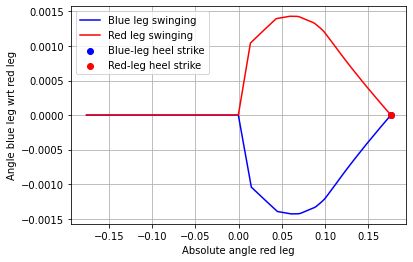

In [26]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], q_opt[:, 4], color='b', label='Blue leg swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 4], - q_opt[:, 4], color='r', label='Red leg swinging')

# scatter heel strikes
plt.scatter(q_opt[0, 2] + q_opt[0, 4], - q_opt[0, 4], color='b', zorder=3, label='Blue-leg heel strike')
plt.scatter(q_opt[0, 2], q_opt[0, 4], color='r', zorder=3, label='Red-leg heel strike')

# misc options
plt.xlabel('Absolute angle red leg')
plt.ylabel('Angle blue leg wrt red leg')
plt.grid(True)
plt.legend()

Here we plot the absolute angle of the red leg versus its time derivative.
Again we complete the cycle by mirroring the result of the trajectory step.

If you did thing correctly, this figure should resemble [Figure 4.10 from the lecture notes](http://underactuated.mit.edu/simple_legs.html#compass_gait) (with reversed signs).
Note that the angle of the red leg is continuous during the walking cycle, while its time derivative has two jumps.

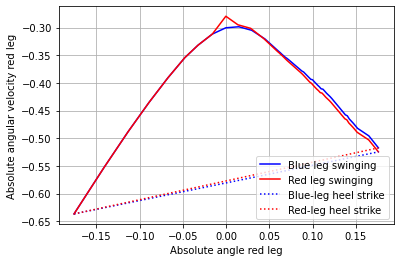

In [27]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], qd_opt[:, 2], color='b', label='Blue leg swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 4], qd_opt[:, 2] + qd_opt[:, 4], color='r', label='Red leg swinging')

# plot heel strikes
plt.plot(
    [q_opt[-1, 2], q_opt[0, 2] + q_opt[0, 4]],
    [qd_opt[-1, 2], qd_opt[0, 2] + qd_opt[0, 4]],
    linestyle=':',
    color='b',
    label='Blue-leg heel strike'
)
plt.plot(
    [q_opt[0, 2], q_opt[-1, 2] + q_opt[-1, 4]],
    [qd_opt[0, 2], qd_opt[-1, 2] + qd_opt[-1, 4]],
    linestyle=':',
    color='r',
    label='Red-leg heel strike'
)

# misc options
plt.xlabel('Absolute angle red leg')
plt.ylabel('Absolute angular velocity red leg')
plt.grid(True)
plt.legend()

Optimal d is:  [0.7]


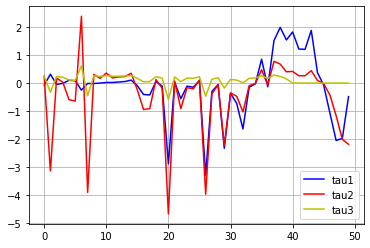

In [28]:
plt.plot(u_opt[:,0],color='b', label='tau1')
plt.plot(u_opt[:,1],color='r', label='tau2')
plt.plot(u_opt[:,2],color='y', label='tau3')
plt.grid(True)
plt.legend()
print("Optimal d is: ", d_opt)

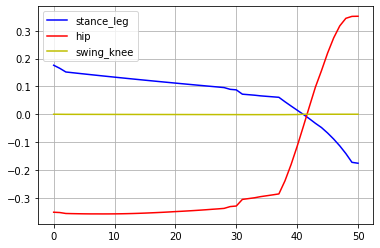

In [29]:
plt.plot(q_opt[:,2],color='b', label='stance_leg')
plt.plot(q_opt[:,3],color='r', label='hip')
plt.plot(q_opt[:,4],color='y', label='swing_knee')
plt.grid(True)
plt.legend()

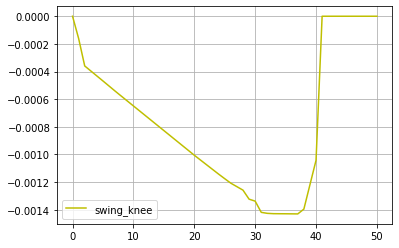

In [30]:
plt.plot(q_opt[:,4],color='y', label='swing_knee')
plt.grid(True)
plt.legend()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
0.0
0.0


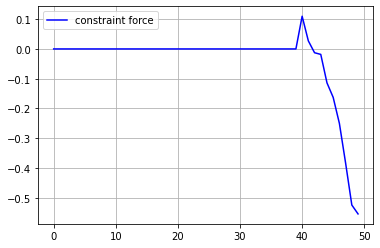

In [31]:
print(type(f_knee_opt))
print(type(q_opt[:,2]))

print(f_knee_opt[1])
print(q_opt[0,0])

plt.plot(f_knee_opt,color='b', label='constraint force')
#plt.plot(q_opt[:,3],color='b', label='constraint force')

plt.grid(True)
plt.legend()